In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from konlpy.utils import partition
import re

# 데이터 가져오기

In [2]:
train=pd.read_csv('data/train.hate.csv')

In [3]:
dev=pd.read_csv('data/dev.hate.csv')

In [4]:
test=pd.read_csv('data/test.hate.no_label.csv')
test_row=pd.read_csv('data/test.hate.no_label.csv')

In [5]:
dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  471 non-null    object
 1   label     471 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7896 entries, 0 to 7895
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  7896 non-null   object
 1   label     7896 non-null   object
dtypes: object(2)
memory usage: 123.5+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  974 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB


In [8]:
train=pd.concat([train,dev])  #7896:

In [9]:
train

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,hate
...,...,...
466,지현우 범죄 저지르지 않았나요?,offensive
467,여자인생 망칠 일 있나 ㅋㅋ,hate
468,근데 전라도에서 사고가 났는데 굳이 서울까지 와서 병원에 가느 이유는?,offensive
469,"할매젖x, 뱃살x, 몸매 s라인, 유륜은 적당해야됨(너무크거나 너무 작아도 x), ...",hate


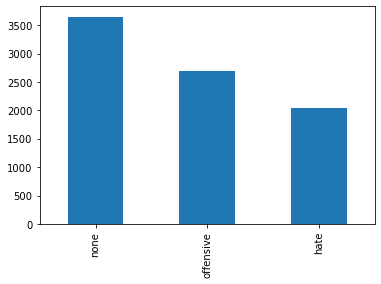

In [10]:
train['label'].value_counts()
train['label'].value_counts().plot(kind='bar')

In [11]:
train['label']=train['label'].map({'none':0,'offensive':1,'hate':2})

In [12]:
train.head()

,comments,label
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,0
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",2
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",0
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,2


# 데이터 전처리

In [13]:
stopword=['아','휴','아이구','아이쿠','아이고','어','나','우리','저희','따라','의해','을','를','에','의','가','으로','로','에게','뿐이다','의거하여','근거하여','입각하여','기준으로',
'예하면','예를 들면','예를 들자면','저','소인','소생','저희','지말고','하지마','하지마라','다른','물론','또한','그리고','비길수 없다','해서는 안된다','뿐만 아니라','만이 아니다',
'만은 아니다','막론하고','관계없이','그치지 않다','그러나','그런데','하지만','든간에','논하지 않다','따지지 않다','설사','비록','더라도','아니면','만' '못하다','하는 편이 낫다',
'불문하고','향하여','향해서','향하다','쪽으로','틈타','이용하여','타다','오르다','제외하고','이 외에','이 밖에','하여야','비로소','한다면' '몰라도','외에도','이곳','여기','부터',
'기점으로,따라서','할 생각이다','하려고하다','이리하여','그리하여','그렇게' '함으로써','하지만','일때','할때','앞에서','중에서','보는데서','으로써','로써','까지','해야한다',
'일것이다','반드시','할줄알다','할수있다','할수있어','임에 틀림없다','한다면','등','등등','제','겨우','단지','다만','할뿐','딩동','댕그','대해서','대하여','대하면','훨씬','얼마나',
'얼마만큼','얼마큼','남짓','여','얼마간','약간','다소','좀','조금','다수','몇','얼마','지만','하물며','또한','그러나','그렇지만','하지만','이외에도','대해 말하자면','뿐이다','다음에',
'반대로','반대로 말하자면','이와 반대로','바꾸어서 말하면','바꾸어서 한다면','만약','그렇지않으면','까악','툭','딱','삐걱거리다','보드득','비걱거리다','꽈당','응당','해야한다',
'에 가서','각','각각','여러분','각종','각자','제각기','하도록하다','와','과','그러므로','그래서','고로','한 까닭에','하기 때문에','거니와','이지만','대하여','관하여','관한','과연',
'실로','아니나다를가','생각한대로','진짜로','한적이있다','하곤하였다','하','하하','허허','아하','거바','와','오','왜','어째서','무엇때문에','어찌','하겠는가','무슨','어디','어느곳',
'더군다나','하물며','더욱이는','어느때','언제','야','이봐','어이','여보시오','흐흐','흥','휴','헉헉','헐떡헐떡','영차','여차','어기여차','끙끙','아야','앗','아야','콸콸','졸졸','좍좍','뚝뚝',
'주룩주룩','솨','우르르','그래도','또','그리고','바꾸어말하면','바꾸어말하자면','혹은','혹시','답다','및','그에 따르는','때가 되어','즉','지든지','설령','가령','하더라도','할지라도',
'일지라도','지든지','몇','거의,하마터면','인젠','이젠','된바에야','된이상','만큼','어찌됏든','그위에','게다가','점에서 보아','비추어 보아','고려하면','하게될것이다','일것이다',
'비교적','좀','보다더','비하면','시키다','하게하다','할만하다','의해서','연이서','이어서','잇따라','뒤따라','뒤이어','결국','의지하여','기대여','통하여','자마자','더욱더','불구하고',
'얼마든지','마음대로','주저하지 않고','곧','즉시','바로','당장','하자마자','밖에' '안된다','하면된다','그래','그렇지','요컨대','다시 말하자면','바꿔 말하면','즉','구체적으로',
'말하자면','시작하여','시초에','이상','허','헉','허걱','바와같이','해도좋다','해도된다','게다가','더구나','하물며','와르르','팍','퍽','펄렁','동안','이래','하고있었다','이었다','에서',
'로부터','까지','예하면','했어요','해요','함께','같이','더불어','마저','마저도','양자','모두','습니다','가까스로','하려고하다','즈음하여','다른','다른 방면으로','해봐요','습니까',
'했어요','말할것도 없고','무릎쓰고','개의치않고','하는것만 못하다','하는것이 낫다','매','매번','들','모','어느것','어느','로써','갖고말하자면','어디','어느쪽','어느것','어느해',
'어느 년도','라' '해도','언젠가','어떤것','어느것','저기','저쪽','저것','그때','그럼','그러면','요만한걸','그래','그때','저것만큼','그저','이르기까지','할 줄 안다','할 힘이' '있다',
'너','너희','당신','어찌','설마','차라리','할지언정','할지라도','할망정','할지언정','구토하다','게우다','토하다','메쓰겁다','옆사람','퉤','쳇','의거하여','근거하여','의해','따라',
'힘입어','그','다음','버금','두번째로','기타','첫번째로','나머지는','그중에서','견지에서','형식으로 쓰여','입장에서','위해서','단지','의해되다','하도록시키다','뿐만아니라',
'반대로','전후','전자','앞의것','잠시','잠깐','하면서','그렇지만','다음에','그러한즉','그런즉','남들','아무거나','어찌하든지','같다','비슷하다','예컨대','이럴정도로','어떻게',
'만약','만일','위에서' '서술한바와같이','인 듯하다','하지 않는다면','만약에','무엇','무슨','어느','어떤','아래윗','조차','한데','그럼에도 불구하고','여전히','심지어','까지도',
'조차도','하지 않도록','않기 위하여','때','시각','무렵','시간','동안','어때','어떠한','하여금','네','예','우선','누구','누가' '알겠는가','아무도','줄은모른다','줄은 몰랏다','하는 김에',
'겸사겸사','하는바','그런 까닭에','한 이유는','그러니','그러니까','때문에','그','너희','그들','너희들','타인','것','것들','너','위하여','공동으로','동시에','하기 위하여','어찌하여',
'무엇때문에','붕붕','윙윙','나','우리','엉엉','휘익','윙윙','오호','아하','어쨋든','만 못하다','하기보다는','차라리,하는 편이 낫다','흐흐','놀라다','상대적으로 말하자면','마치',
'아니라면','쉿','그렇지 않으면','그렇지' '않다면','안 그러면','아니었다면','하든지','아니면','이라면','좋아','알았어','하는것도','그만이다','어쩔수 없다','하나','일','일반적으로',
'일단','한켠으로는','오자마자','이렇게되면','이와같다면','전부','한마디','한항목','근거로','하기에','아울러','하지 않도록','않기 위해서','이르기까지','이 되다','로 인하여',
'까닭으로','이유만으로','이로 인하여','그래서','이 때문에','그러므로','그런 까닭에','알 수 있다','결론을 낼 수 있다','으로 인하여','있다','어떤것','관계가 있다','관련이 있다',
'연관되다','어떤것들','에 대해','이리하여','그리하여','여부','하기보다는','하느니','하면 할수록','운운','이러이러하다','하구나','하도다','다시말하면','다음으로','에 있다',
'에 달려 있다','우리','우리들','오히려','하기는한데','어떻게','어떻해','어찌됏어','어때','어째서','본대로','자','이','이쪽','여기','이것','이번','이렇게말하자면','이런','이러한',
'이와 같은','요만큼','요만한 것','얼마 안 되는 것','이만큼','이 정도의','이렇게 많은 것','이와 같다','이때','이렇구나','것과 같이','끼익','삐걱,따위','와 같은 사람들',
'부류의 사람들','왜냐하면','중의하나','오직','오로지','에 한하다','하기만 하면','도착하다','까지 미치다','도달하다','정도에 이르다','할 지경이다','결과에 이르다','관해서는',
'여러분','하고 있다','한 후','혼자','자기','자기집','자신','우에' '종합한것과같이','총적으로' '보면','총적으로' '말하면','총적으로','대로 하다','으로서','참','그만이다','할 따름이다','쿵',
'탕탕','쾅쾅','둥둥','봐','봐라','아이야','아니','와아','응','아이','참나','년','월','일','령','영','일','이','삼','사','오','육','륙','칠','팔','구','이천육','이천칠','이천팔','이천구','하나','둘','셋',
'넷','다섯','여섯','일곱','여덟','아홉','령','영','게뭐','그거','그건','그걸','그것','그게','런가','려고','로는','리가','리기','마다','뭐라다', '뭐임', '뭔가','아직','아직도','으로가', '으로는', '으로도', '으로만', '으론','이건','이고', '이구나', '이구만','이군','이냐', '이네', '이니', '이니까', '이다','이던','이든','이딴', '이라', '이라고', '이라는', '이라니', '이라도', '이라서', '이래서', '이러니', '이렇게', '이렇다','하고도','하나요','하니', '하다', '하든', '하라','하여간', '하여튼', '하자']

In [14]:
addstopword=['']

In [15]:
wordDict={"[\W+]":" ",'[\d+]':' ','[ㅡ+]':'','[ㅠ+]':'','[ㅜ+]':'','[ㄱ-ㅎ]':'','[ㅏ-ㅣ]':'','ᆢᆢ':''}

In [16]:
for i,j in wordDict.items():
    train['comments']=train.comments.str.replace(i,j)
    test['comments']=test.comments.str.replace(i,j)

In [17]:
def cw(x):
    simdict={'추카':'축하'
            }
    for index,word in simdict.items():
        return re.sub(index,word,x)

In [18]:
train['comments']=train.comments.apply(cw)
test['comments']=test.comments.apply(cw)

In [19]:
train.head()

,comments,label
0,현재 호텔주인 심정 아 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,2
1,한국적인 미인의 대표적인 분 너무나 곱고아름다운모습 그모습뒤의 슬픔을...,0
2,못된 넘들 남의 고통을 즐겼던 넘들 이젠 마땅한 처벌을 받아야지 그래...,2
3,화 어설펐는데 화 지나서부터는 갈수록 너무 재밌던데,0
4,사람 얼굴 손톱으로 긁은것은 인격살해이고 동영상이 몰카냐 메걸리안들 생각...,2


### 문자=> 숫자 (단어 길이와 빈도수를 조절)

In [20]:
n=2  #단어 길이
m=5  # 빈도수

In [21]:
okt=Okt()
wordList=[]
word_index={}
wordCount={}
train['corpus']=0
for index ,sentencs in enumerate(train.comments):
    words=okt.morphs(sentencs,stem=True)
    train['corpus'].iloc[index]=words
    for word in words:
        if word not in stopword:
            if len(word) >= n:
                if word not in wordList:
                    wordCount[word]=1
                    wordList.append(word)
                else:
                    wordCount[word]=wordCount[word]+1
wordList=[]                
for words in train['corpus']:
    for word in words:
        if word not in stopword:
            if len(word) >=n:
                if wordCount[word] >= m:
                    if word not in wordList:
                        word_index[word]=len(wordList)
                        wordList.append(word)

C:\Users\i\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
testarray=[]
test['corpus']=0
for index ,sentencs in enumerate(test.comments):
    words=okt.morphs(sentencs,stem=True)
    test['corpus'].iloc[index]=words
    temp=[0]*len(word_index)
    for word in words:
        if word in word_index.keys():
            temp[word_index[word]]=1
    testarray.append(temp)

In [23]:
print(sorted(word_index.keys()))

['KBS', 'OOO', 'SM', 'SNS', 'TV', 'YG', 'jyp', 'kbs', 'kg', 'mc', 'sm', 'sns', 'yg', '가게', '가관', '가기', '가끔', '가나', '가능성', '가능하다', '가다', '가득하다', '가라', '가르다', '가르치다', '가리다', '가만히', '가면', '가볍다', '가보', '가보다', '가세', '가수', '가슴', '가식', '가야', '가요', '가장', '가정', '가족', '가즈', '가지', '가지가지', '가지다', '가짜', '가해자', '간다', '갈다', '갈수록', '갈아', '감다', '감독', '감동', '감사하다', '감성', '감옥', '감정', '감정이입', '감탄', '감히', '갑자기', '강간', '강남', '강성훈', '강요', '강용석', '강은비', '강지환', '강타', '강하다', '강한나', '강호동', '갖다', '갖추다', '같잖다', '갚다', '개그', '개그맨', '개그우먼', '개념', '개다', '개돼지', '개뿔', '개월', '개인', '개판', '거기', '거나', '거들다', '거래', '거리', '거부', '거슬리다', '거울', '거의', '거임', '거지', '거짓', '거짓말', '거참', '거품', '걱정', '건가', '건강', '건강하다', '건데', '건드리다', '건물', '건지다', '걷다', '걸그룹', '걸다', '걸리다', '검다', '검사', '검색', '검색어', '검찰', '겁나다', '겁니다', '게스트', '게이', '게임', '겠다', '겪다', '결과', '결론', '결말', '결정', '결혼', '결혼식', '겸손하다', '경기', '경우', '경제', '경찰', '계속', '계시다', '계약', '계집', '고딩', '고르다', '고마', '고만', '고맙다', '고발', '고백', '고사', '고생', '고소', '고소영', '고소하다', '고요', '고인', '고정', '고주원

### Document Term Matrix

In [24]:
trainarray=[]
for corpus in train.corpus:
    temp=[0]*len(word_index)
    for word in corpus:
        if word in word_index.keys():
            temp[word_index[word]]=+1
    trainarray.append(temp)

In [25]:
dtm=pd.DataFrame(trainarray,columns=word_index.keys())

In [26]:
dtm.shape

(8367, 2284)

### one hot encoding

In [27]:
trainarray=[]
for corpus in train.corpus:
    temp=[0]*len(word_index)
    for word in corpus:
        if word in word_index.keys():
            temp[word_index[word]]=1
    trainarray.append(temp)

In [28]:
ohe=pd.DataFrame(trainarray,columns=word_index.keys())

In [29]:
ohe.shape

(8367, 2284)

### xTrain yTrain xTest 생성

In [30]:
xTrain=ohe.values
yTrain=train['label'].values
xTest=testarray

### naive_bayes

In [31]:
from sklearn.naive_bayes import CategoricalNB

In [32]:
model=CategoricalNB()
model.fit(xTrain, yTrain)

CategoricalNB()

In [33]:
pred=model.predict(xTest)

In [34]:
model.score(xTrain , yTrain)

0.6960678857416039

In [35]:
test_row['label']=pred
submit_NB=test_row[['comments','label']]

In [36]:
submit_NB.to_csv('submit_NB.csv',index=False)

### 신경망

In [65]:
from keras.models import Sequential 
from keras.layers import Dense
from keras import optimizers

In [66]:
model=Sequential()
model.add(Dense(729,input_shape=(xTrain.shape[1],) ,activation='relu'))
model.add(Dense(729,activation='relu'))
model.add(Dense(243,activation='relu'))
model.add(Dense(81,activation='relu'))
model.add(Dense(3,activation='softmax'))

In [67]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [68]:
train['none']=train['label']==0
train['offensive']=train['label']==1
train['hate']=train['label']==2
yTrain=train[['none','offensive','hate']].values
yTrain

array([[False, False,  True],
       [ True, False, False],
       [False, False,  True],
       ...,
       [False,  True, False],
       [False, False,  True],
       [ True, False, False]])

In [69]:
x_val = xTrain[:1000]
partial_x_train = xTrain[1000:]

y_val = yTrain[:1000]
partial_y_train = yTrain[1000:]

In [70]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=1024,
                    validation_data=(x_val, y_val))

Epoch 1/30
8/8 [==============================] - 1s 141ms/step - loss: 1.0701 - accuracy: 0.4184 - val_loss: 1.0617 - val_accuracy: 0.4310
Epoch 2/30
8/8 [==============================] - 1s 88ms/step - loss: 0.9282 - accuracy: 0.5420 - val_loss: 0.9949 - val_accuracy: 0.5220
Epoch 3/30
8/8 [==============================] - 1s 92ms/step - loss: 0.7345 - accuracy: 0.6814 - val_loss: 0.9310 - val_accuracy: 0.5730
Epoch 4/30
8/8 [==============================] - 1s 94ms/step - loss: 0.5854 - accuracy: 0.7504 - val_loss: 1.0669 - val_accuracy: 0.5590
Epoch 5/30
8/8 [==============================] - 1s 91ms/step - loss: 0.4658 - accuracy: 0.8151 - val_loss: 1.1014 - val_accuracy: 0.5640
Epoch 6/30
8/8 [==============================] - 1s 90ms/step - loss: 0.3501 - accuracy: 0.8674 - val_loss: 1.3347 - val_accuracy: 0.5610
Epoch 7/30
8/8 [==============================] - 1s 88ms/step - loss: 0.2573 - accuracy: 0.9066 - val_loss: 1.5291 - val_accuracy: 0.5580
Epoch 8/30
8/8 [==========

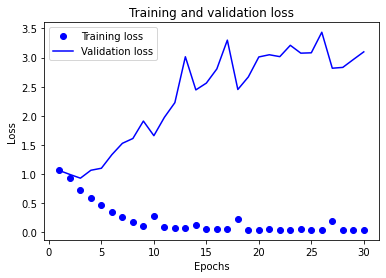

In [71]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo',label="Training loss" )
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

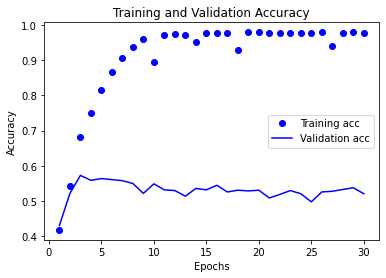

In [72]:
plt.clf() #그래프 초기화 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()

In [73]:
pred=model.predict(xTest)

In [74]:
predict=[]
for i in pred:
    predict.append(i.argmax())

In [75]:
test_row['label']=predict

In [76]:
submit_MC=test_row[['comments','label']]

In [77]:
submit_MC.to_csv('submit_MC.csv',index=False)

In [78]:
submit_MC['label'].value_counts()

0    464
1    382
2    128
Name: label, dtype: int64

In [79]:
submit_MC

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,1
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,1
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,2


In [80]:
submit_NB

,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,0
1,둘다 넘 좋다~행복하세요,0
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,1
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,0
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,0
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,1
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,1
